In [8]:
%matplotlib inline

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)




plot_num = 1
count_nearest = 10
n_clusters = 3

#We are looking at 3 types of data
datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240, 'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (blobs, {})]

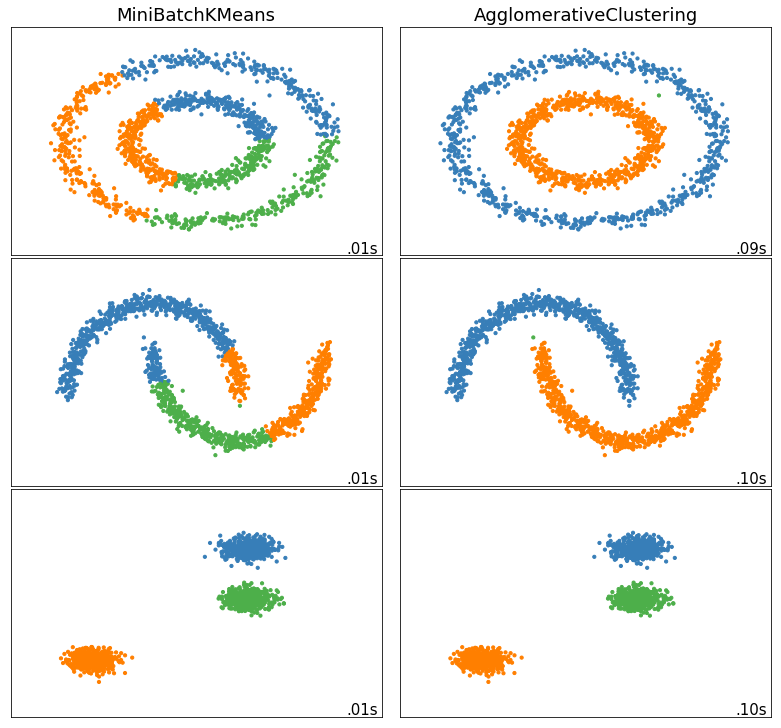

In [9]:
# Matplotlib Parameters. Check manual for more details
plt.figure(figsize=(2 * 4 + 3, 10))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,hspace=.01)
for i_dataset, (dataset, algo_params) in enumerate(datasets):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=count_nearest, include_self=False)
    connectivity = 0.5 * (connectivity + connectivity.T) #Make it symmetric

    # ============
    # Create cluster objects
    # ============

    two_means = cluster.MiniBatchKMeans(n_clusters=n_clusters) #K-Means Cluster
    average_linkage = cluster.AgglomerativeClustering(linkage="average", affinity="cityblock",n_clusters=n_clusters, connectivity=connectivity) #Hierarchical Clustering


    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AgglomerativeClustering', average_linkage)
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()
          
        
        ###### IGNORE THIS BIT FOR NOW   ##########
        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
        ############################################
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()